In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = 'C:/Program Files/ffmpeg/bin/ffmpeg.exe'
import time
from celluloid import Camera
from IPython.display import HTML

In [2]:
def updateQV(oldQ, oldV, i):
    # TODO
    newQ = [[0,0,0],[np.cos(i*0.0628),np.sin(i*0.0628),0]]
    newV = oldV
    return newQ, newV

<IPython.core.display.Javascript object>


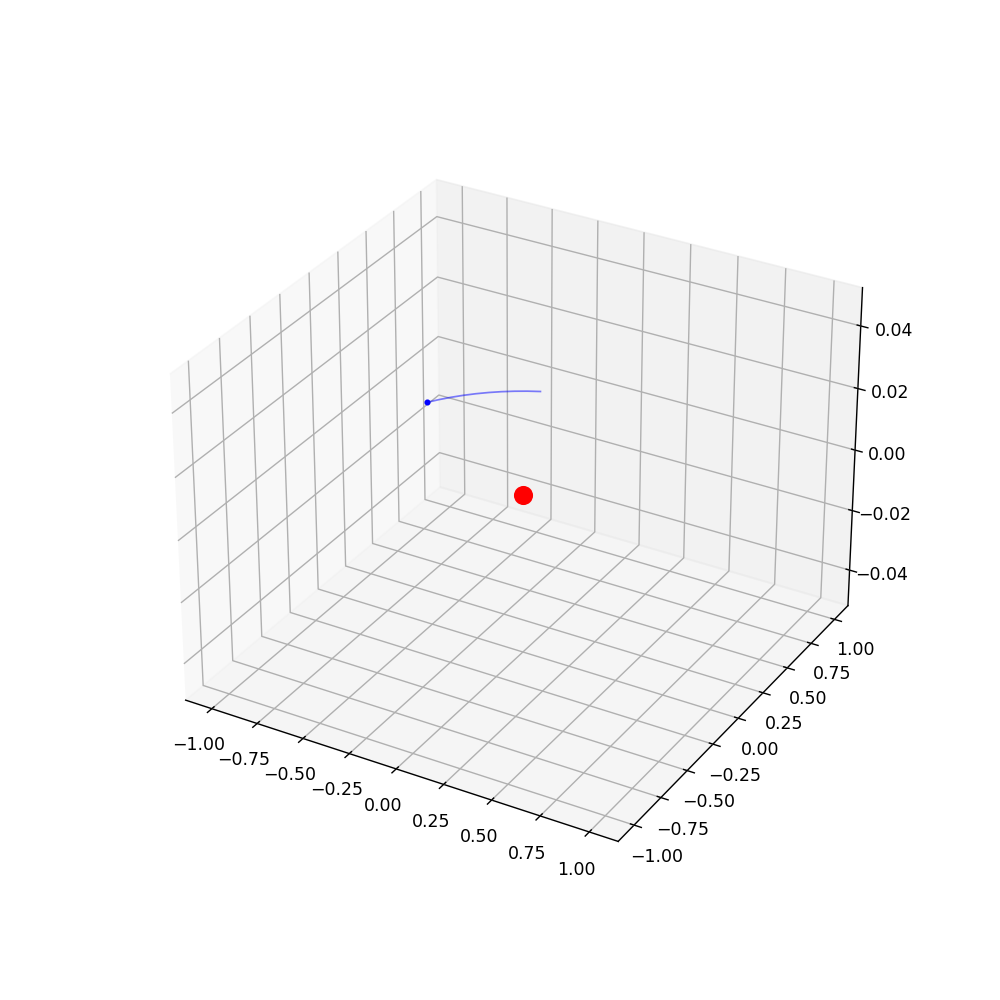

In [3]:
numberTimeSteps = 100
storedTimeSteps = 10
updateFn = updateQV

names = ["Sun", "BigSun"]
numObjs = len(names)
m = [1, 2]

q = np.empty((storedTimeSteps,numObjs,3))
q[:] = np.nan
v = np.empty((storedTimeSteps,numObjs,3))
v[:] = np.nan
index = 0
q[index] = [[0,0,0],[1,0,0]]
v[index] = [[0,0,0],[0,1,0]]

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(projection='3d')
camera = Camera(fig)

for i in range(numberTimeSteps):
    
    oldQ = q[index]
    oldV = v[index]
    # TODO
    newQ, newV = updateQV(oldQ, oldV, i+1)
    # TODO
    index = ((index + 1) % storedTimeSteps)
    q[index] = newQ
    v[index] = newV
    
    ax = fig.gca()
    ax.plot(newQ[0][0], newQ[0][1], newQ[0][2], color = 'red', marker = 'o', markersize=10)
    for j in range(1, numObjs):
        ax.plot(newQ[j][0], newQ[j][1], newQ[j][2], color = 'blue', marker = '.', markersize=5)
    
    reorderQ = np.append(q[index+1:storedTimeSteps], q[0:index+1], axis=0)
    ax.plot(reorderQ[:,0,0], reorderQ[:,0,1], reorderQ[:,0,2], color = 'red', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
    for j in range(1, numObjs):
        ax.plot(reorderQ[:,j,0], reorderQ[:,j,1], reorderQ[:,j,2], color = 'blue', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
    
    camera.snap()
    
animation = camera.animate()
# HTML(animation.to_html5_video())